In [229]:
#Ucitavanje biblioteka

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot, plot
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from kneed import KneeLocator
import time
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster


In [230]:
#Ucitavanje csv fajla

data = pd.read_csv('songs_normalize.csv')
data.head(4)

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.355,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.612,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.251,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.347,0.544,119.992,"rock, metal"


In [231]:
#Izmjena naziva kolona, capslk

data.rename(columns={'artist':'Artist', 'song':'Song', 'duration_ms':'Duration_MS', 'explicit':'Explicit', 
                     'year':'Year','popularity':'Popularity','danceability':'Danceability',
                     'energy':'Energy', 'key':'Key', 'loudness':'Loudness', 'mode':'Mode', 
                     'speechiness':'Speechiness', 'acousticness':'Acousticness', 
                     'instrumentalness':'Instrumentalness', 'liveness':'Liveness', 
                     'valence':'Valence', 'tempo':'Tempo','genre':'Genre'},inplace=True)

In [232]:
#Duplikati

data.duplicated().sum()

59

In [233]:
#Brisanje duplikata

data.drop_duplicates(inplace=True)

In [234]:
#Koliko je pjesama izvan opsega 2000-2019

years_of_interest = [1999, 1998, 2020]
filtered_data = data[data['Year'].isin(years_of_interest)]

song_year = filtered_data['Year'].value_counts().reset_index()
song_year.columns = ['Year', 'Number of songs']

song_year

,Year,Number of songs
0,1999,38
1,2020,3
2,1998,1


In [235]:
#Posto nas zanimaju samo godine od 2000-2019, brisemo godine izvan tog opsega

data_years_drop = data[(data['Year'] <2000) | (data['Year'] > 2019)].index
data = data.drop(data_years_drop)
print(data.Year.unique())
data.head(5)

[2000 2001 2011 2002 2016 2018 2004 2010 2015 2006 2008 2019 2003 2013
 2005 2012 2007 2009 2017 2014]


,Artist,Song,Duration_MS,Explicit,Year,Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop
6,Eminem,The Real Slim Shady,284200,True,2000,86,0.949,0.661,5,-4.244,0,0.0572,0.0302,0.000000,0.0454,0.760,104.504,hip hop
7,Robbie Williams,Rock DJ,258560,False,2000,68,0.708,0.772,7,-4.264,1,0.0322,0.0267,0.000000,0.4670,0.861,103.035,"pop, rock"


In [236]:
data.shape

(1899, 18)

In [237]:
data.columns

Index(['Artist', 'Song', 'Duration_MS', 'Explicit', 'Year', 'Popularity',
       'Danceability', 'Energy', 'Key', 'Loudness', 'Mode', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Genre'],
      dtype='object')

In [238]:
data.describe()

,Duration_MS,Year,Popularity,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo
count,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000,1899.000000
mean,228123.525540,2009.720379,59.558715,0.667637,0.721256,5.379147,-5.503538,0.553976,0.104413,0.127722,0.015525,0.181934,0.552579,120.115425
std,39116.687604,5.725938,21.683909,0.140547,0.152511,3.610882,1.931067,0.497209,0.096523,0.172951,0.089036,0.140827,0.220361,26.986107
min,113000.000000,2000.000000,0.000000,0.129000,0.054900,0.000000,-20.514000,0.000000,0.023200,0.000019,0.000000,0.021500,0.038100,60.019000
25%,203273.000000,2005.000000,56.000000,0.581000,0.624500,2.000000,-6.480000,0.000000,0.039900,0.013550,0.000000,0.088750,0.389500,98.605000
50%,222920.000000,2010.000000,65.000000,0.676000,0.738000,6.000000,-5.279000,1.000000,0.061300,0.055300,0.000000,0.125000,0.559000,120.028000
75%,247086.000000,2015.000000,73.000000,0.765000,0.839000,8.000000,-4.167000,1.000000,0.130500,0.175000,0.000064,0.242000,0.730500,134.124500
max,484146.000000,2019.000000,89.000000,0.975000,0.999000,11.000000,-0.276000,1.000000,0.576000,0.976000,0.985000,0.853000,0.973000,210.851000


Najbolji Silhouette Score: 0.605 za broj klastera: 3


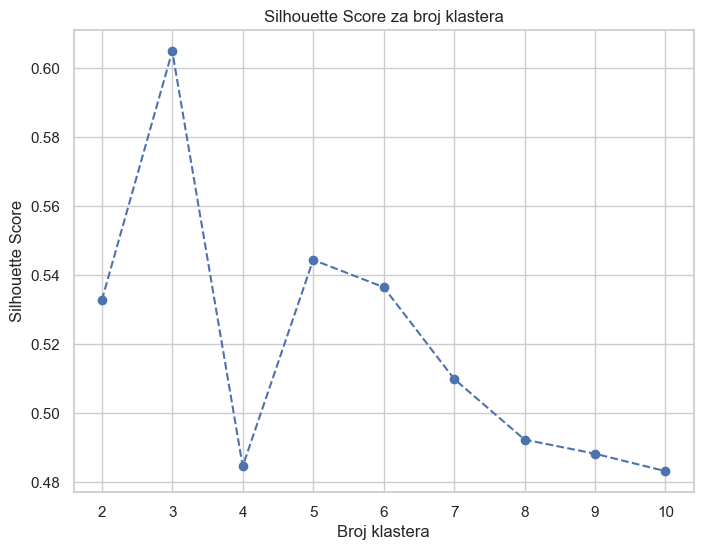

In [239]:
#Silhoutte score

features = [ 'Danceability', 'Energy', 'Loudness', 'Speechiness', 'Acousticness', 'Instrumentalness', 'Tempo']
X = data[features]

#X = X.apply(pd.to_numeric, errors='coerce')
#X = X.fillna(X.mean())

scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X.drop(columns=[ 'Loudness','Tempo']))
X_scaled= np.hstack([X_scaled, np.array(data[['Loudness','Tempo']])])

silhouette_scores = []

for i in range(2, 11):
     kmeans=KMeans(n_clusters=i, init=init, n_init = 10)
    labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)

max_silhouette_score = max(silhouette_scores)
optimal_clusters = silhouette_scores.index(max_silhouette_score) + 2  

print(f"Najbolji Silhouette Score: {max_silhouette_score:.3f} za broj klastera: {optimal_clusters}")

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score za broj klastera')
plt.xlabel('Broj klastera')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

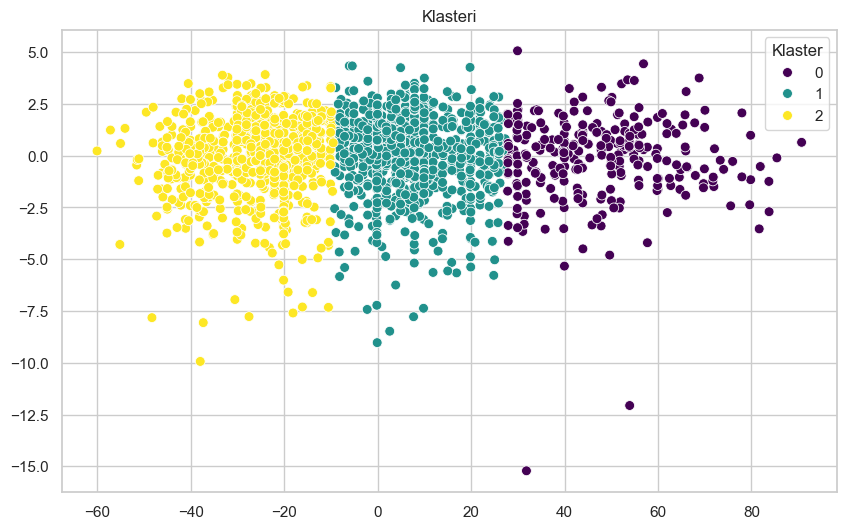

In [240]:
from sklearn.cluster import KMeans
import seaborn as sns

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)

# Promijenite metodu inicijalizacije centara klastera na 'random'
# Defaultna metoda je 'k-means++'
kmeans = KMeans(n_clusters=3, init='random',  max_iter=10000, tol=1e-4, random_state=1)
clusters = kmeans.fit_predict(X_pca)
data['Cluster'] = clusters

# Vizualizacija klastera
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['Cluster'], palette='viridis', s=50)
plt.title('Klasteri')
plt.legend(title='Klaster')
plt.show()


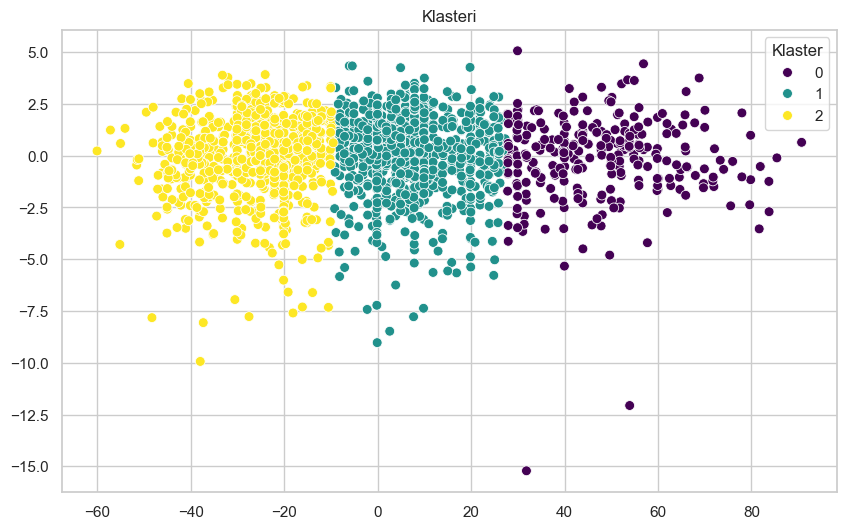

In [241]:
#Klasteri

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled)

kmeans = KMeans(n_clusters=3,random_state=1)
clusters = kmeans.fit_predict(X_pca)
data['Cluster'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data['Cluster'], palette='viridis', s=50)
plt.title('Klasteri')
plt.legend(title='Klaster')
plt.show()

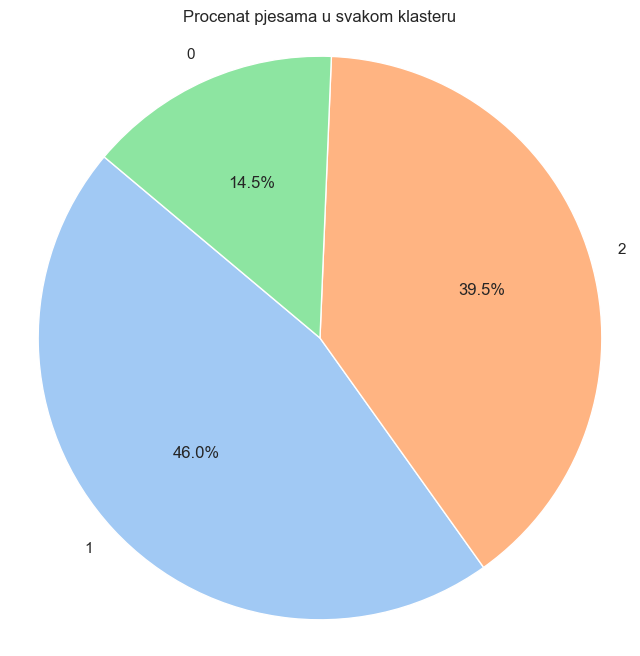

In [242]:
#Raposdjela pjesama

cluster_counts = data['Cluster'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("pastel", len(cluster_counts)))
plt.title('Procenat pjesama u svakom klasteru')
plt.axis('equal')
plt.show()

In [243]:
cluster_means = data.groupby('Cluster')[features].mean()
cluster_means

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Tempo
Cluster,,,,,,,
0,0.582953,0.737232,-5.340359,0.150804,0.112972,0.011988,167.513496
1,0.686537,0.745017,-5.407952,0.081773,0.112290,0.023360,127.624801
2,0.676801,0.687720,-5.674849,0.113693,0.151111,0.007707,93.932021


In [244]:
cluster_0_songs = data[data['Cluster'] == 0][['Song', 'Artist']].head(5)
print(cluster_0_songs)

cluster_1_songs = data[data['Cluster'] == 1][['Song', 'Artist']].head(20)
print(cluster_1_songs)

cluster_2_songs = data[data['Cluster'] == 2][['Song', 'Artist']].head(5)
print(cluster_2_songs)

lewis = data[data['Artist']=='Red Hot Chili Peppers'][['Song','Cluster']]
lewis



                        Song        Artist
4                Bye Bye Bye        *NSYNC
12                Freestyler  Bomfunk MC's
80  Hemorrhage (In My Hands)          Fuel
86          It's Gonna Be Me        *NSYNC
87                  Bag Lady   Erykah Badu
                                                 Song           Artist
3                                        It's My Life         Bon Jovi
9                              Lady - Hear Me Tonight            Modjo
10                                   L'Amour Toujours  Gigi D'Agostino
17                                   Better Off Alone     Alice Deejay
22                                   It Feels So Good          Sonique
26                                          Sandstorm           Darude
28                                    The Time Is Now           Moloko
29                                      Don't Give Up          Chicane
31                                      Dance with Me   Debelah Morgan
32                              

,Song,Cluster
247,Can't Stop,2
280,By the Way,1
671,Dani California,2
798,Snow (Hey Oh),2
1183,The Adventures of Rain Dance Maggie,2


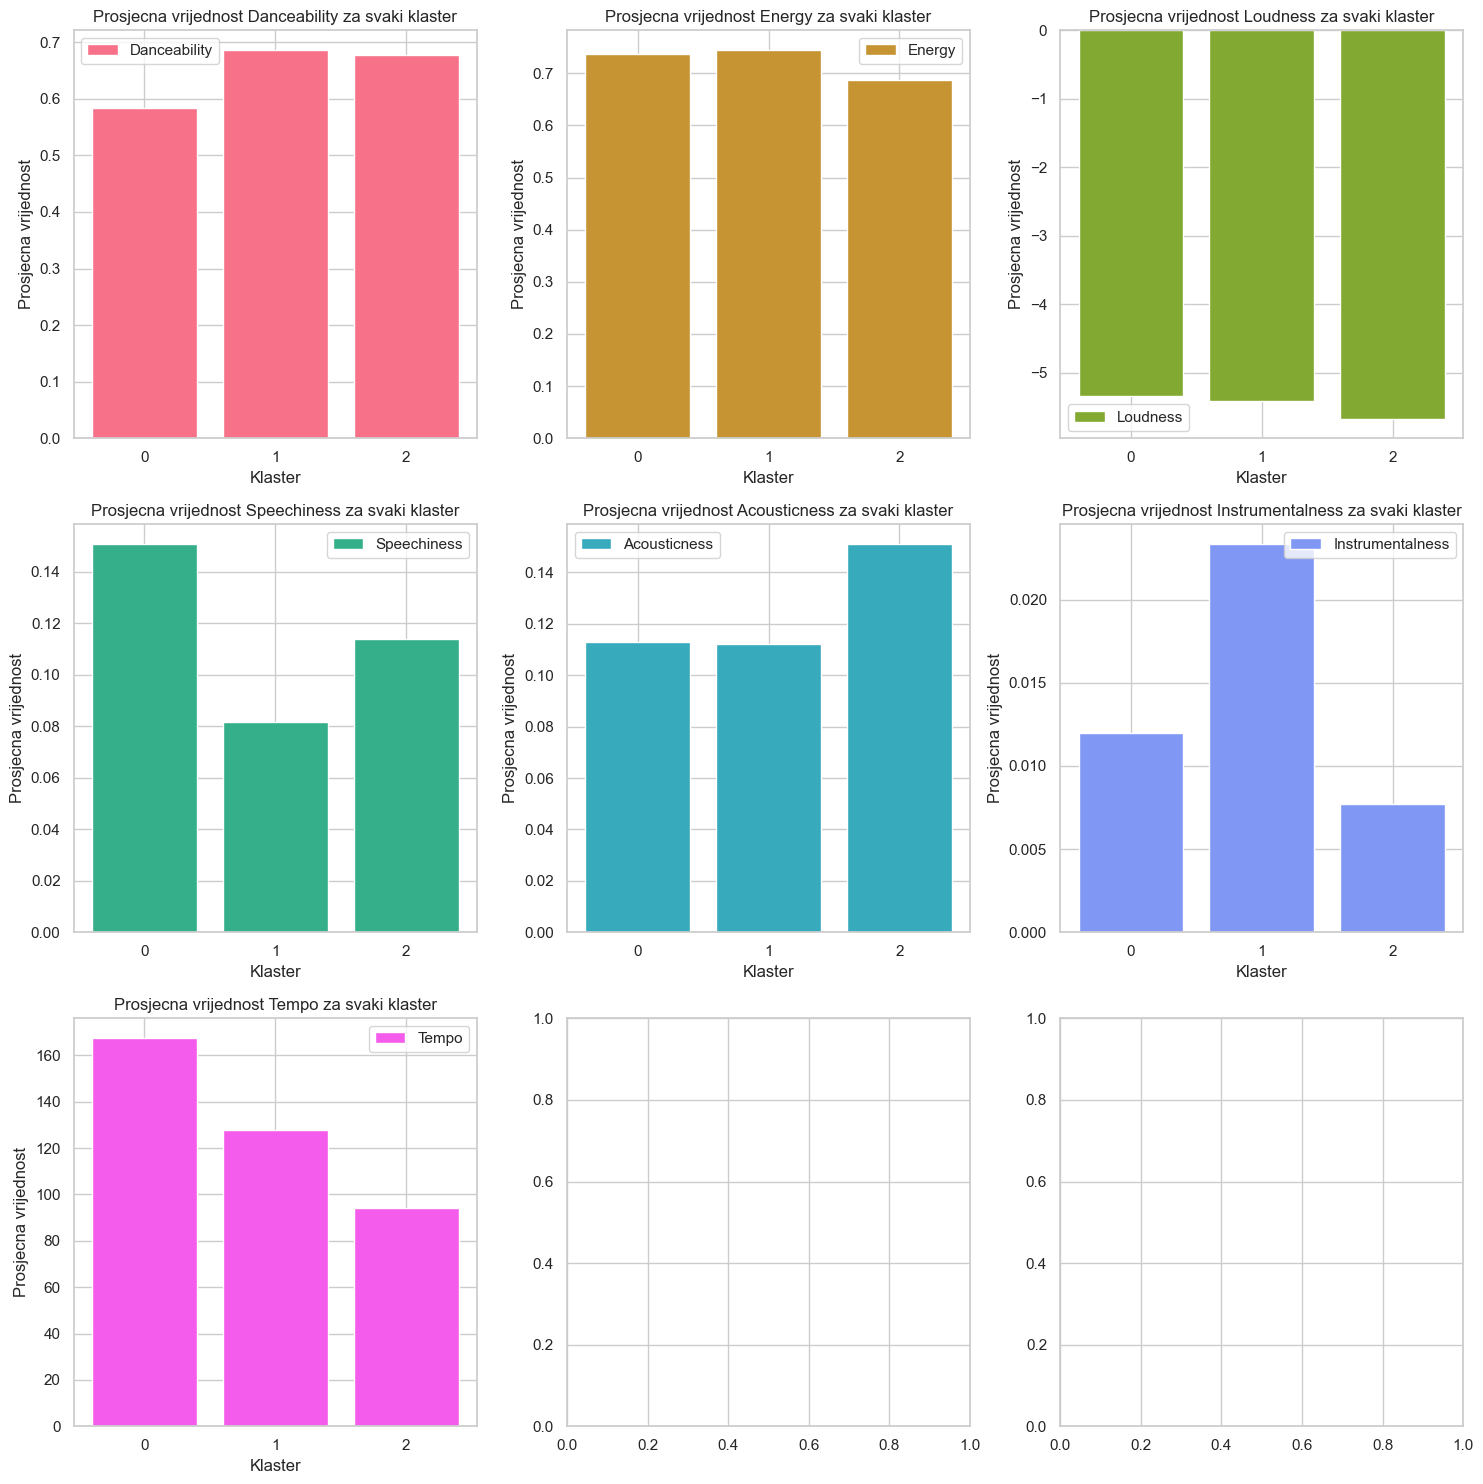

In [245]:
#Raspodjela karakteristika po klasterima

cluster_means = data.groupby('Cluster')[features].mean()

sns.set(style="whitegrid")
colors = sns.color_palette("husl", len(features))

num_cols = min(len(features), 3)
num_rows = (len(features) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    ax.bar(cluster_means.index, cluster_means[feature], color=colors[i], label=feature)
    ax.set_xlabel('Klaster')
    ax.set_ylabel('Prosjecna vrijednost')
    ax.set_title(f'Prosjecna vrijednost {feature} za svaki klaster')
    ax.set_xticks(cluster_means.index) 
    ax.set_xticklabels(cluster_means.index)
    ax.legend()


plt.tight_layout()
plt.show()

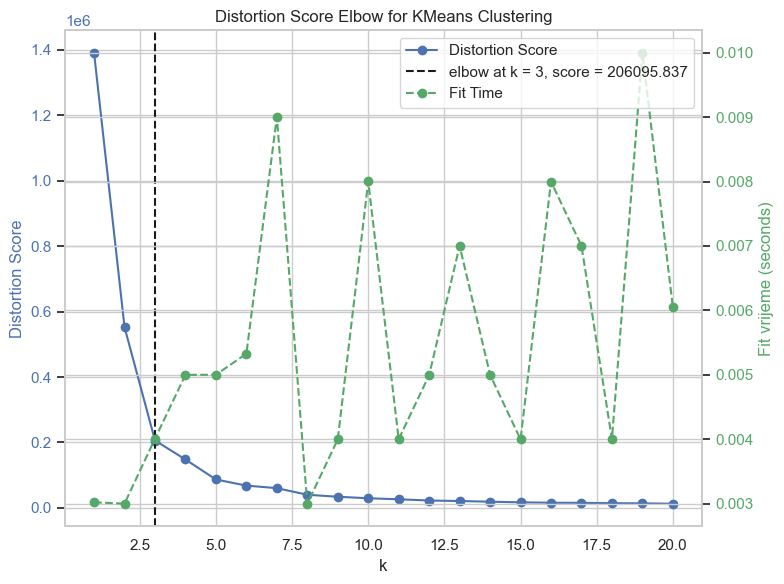

Optimalan broj klastera: 3


In [246]:
#Elbow metoda

distortion_scores = []
fit_times = []

for i in range(1, 21):
    start_time = time.time()
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    end_time = time.time()
    distortion_scores.append(kmeans.inertia_)
    fit_times.append(end_time - start_time)

fig, ax1 = plt.subplots(figsize=(8, 6))

ax1.plot(range(1, 21), distortion_scores, 'b-o', label='Distortion Score')
ax1.set_xlabel('k')
ax1.set_ylabel('Distortion Score', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_title('Distortion Score Elbow for KMeans Clustering')

kneedle = KneeLocator(range(1, 21), distortion_scores, curve='convex', direction='decreasing')
optimal_clusters = kneedle.elbow
ax1.axvline(x=optimal_clusters, color='k', linestyle='--', label=f'elbow at k = {optimal_clusters}, score = {distortion_scores[optimal_clusters-1]:.3f}')

ax2 = ax1.twinx()
ax2.plot(range(1, 21), fit_times, 'g--o', label='Fit Time')
ax2.set_ylabel('Fit vrijeme (seconds)', color='g')
ax2.tick_params(axis='y', labelcolor='g')
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.grid(True)
plt.show()
print(f"Optimalan broj klastera: {optimal_clusters}")

Najbolji Silhouette Score: 0.614 za broj klastera: 3


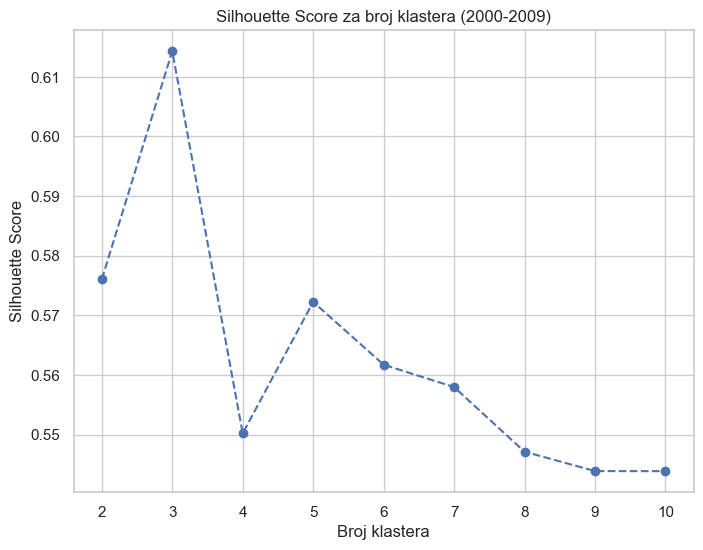

In [247]:
#SILHOUETTE SCORE 2000-2009
data_2000_2009 = data[(data['Year'] >= 2000) & (data['Year'] <= 2009)]
X_2000_2009 = data_2000_2009[features]


scaler = MinMaxScaler()
X_scaled_2000_2009 = scaler.fit_transform(X_2000_2009.drop(columns=[ 'Tempo']))
X_scaled_2000_2009 = np.hstack([X_scaled_2000_2009, np.array(data_2000_2009[['Tempo']])])

silhouette_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X_scaled_2000_2009)
    silhouette_avg = silhouette_score(X_scaled_2000_2009, labels)
    silhouette_scores.append(silhouette_avg)

max_silhouette_score = max(silhouette_scores)
optimal_clusters = silhouette_scores.index(max_silhouette_score) + 2  

print(f"Najbolji Silhouette Score: {max_silhouette_score:.3f} za broj klastera: {optimal_clusters}")

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score za broj klastera (2000-2009)')
plt.xlabel('Broj klastera')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

C:\Users\Sara\AppData\Local\Temp\ipykernel_62224\1456321518.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



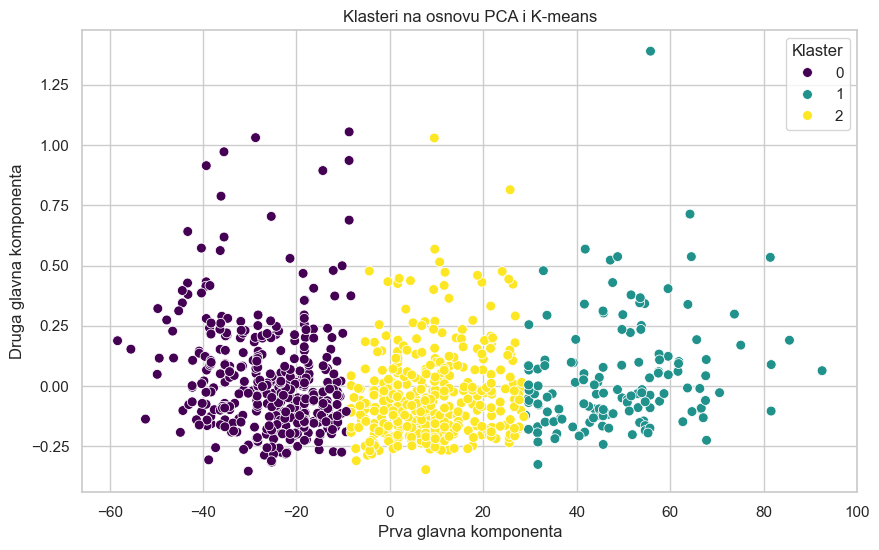

In [248]:
#KLASTEOVANJE 2000-2009
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled_2000_2009)


kmeans = KMeans(n_clusters=3, random_state=1)
clusters = kmeans.fit_predict(X_pca)

data_2000_2009['Cluster1'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data_2000_2009['Cluster1'], palette='viridis', s=50)
plt.title('Klasteri na osnovu PCA i K-means')
plt.xlabel('Prva glavna komponenta')
plt.ylabel('Druga glavna komponenta')
plt.legend(title='Klaster')
plt.show()


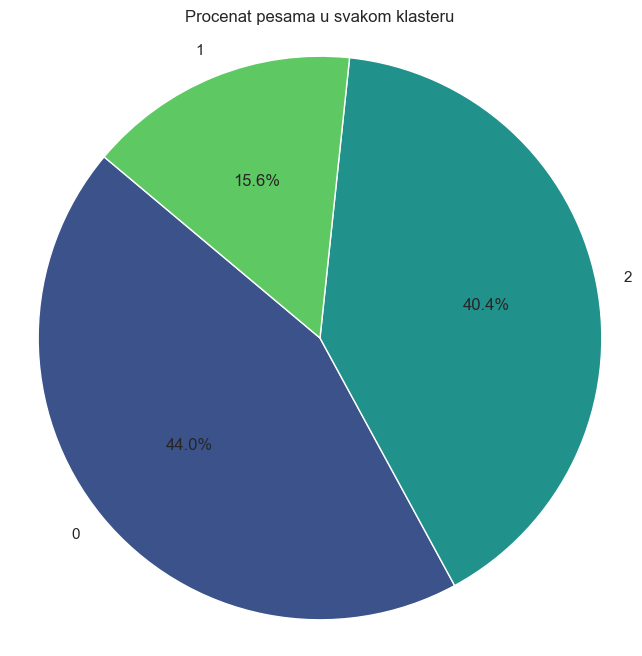

In [249]:
cluster_counts = data_2000_2009['Cluster1'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(cluster_counts)))
plt.title('Procenat pesama u svakom klasteru')
plt.axis('equal')
plt.show()

Najbolji Silhouette Score: 0.620 za broj klastera: 3


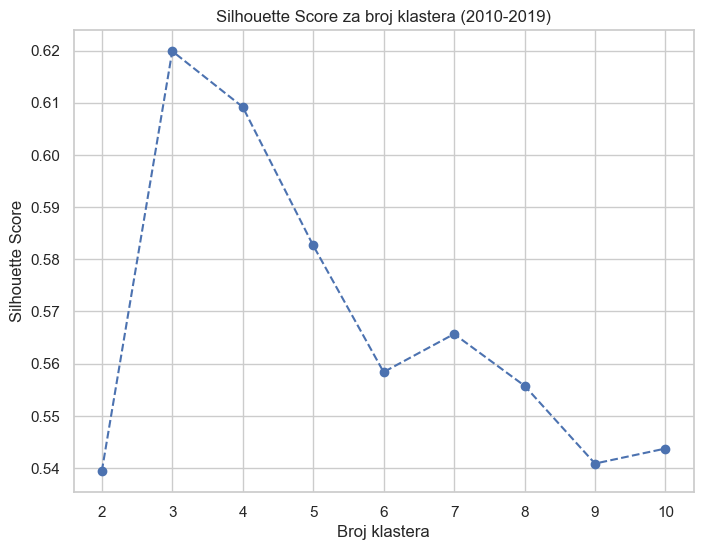

In [250]:
#SILHOUETTE SCORE 2010-2019

data_2010_2019 = data[(data['Year'] >= 2010) & (data['Year'] <= 2019)]
X_2010_2019 = data_2010_2019[features]

scaler = MinMaxScaler()
X_scaled_2010_2019 = scaler.fit_transform(X_2010_2019.drop(columns=[ 'Tempo']))
X_scaled_2010_2019 = np.hstack([X_scaled_2010_2019, np.array(data_2010_2019[['Tempo']])])

silhouette_scores = []

for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    labels = kmeans.fit_predict(X_scaled_2010_2019)
    silhouette_avg = silhouette_score(X_scaled_2010_2019, labels)
    silhouette_scores.append(silhouette_avg)

max_silhouette_score = max(silhouette_scores)
optimal_clusters = silhouette_scores.index(max_silhouette_score) + 2 

print(f"Najbolji Silhouette Score: {max_silhouette_score:.3f} za broj klastera: {optimal_clusters}")


plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--')
plt.title('Silhouette Score za broj klastera (2010-2019)')
plt.xlabel('Broj klastera')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()


C:\Users\Sara\AppData\Local\Temp\ipykernel_62224\4179552605.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



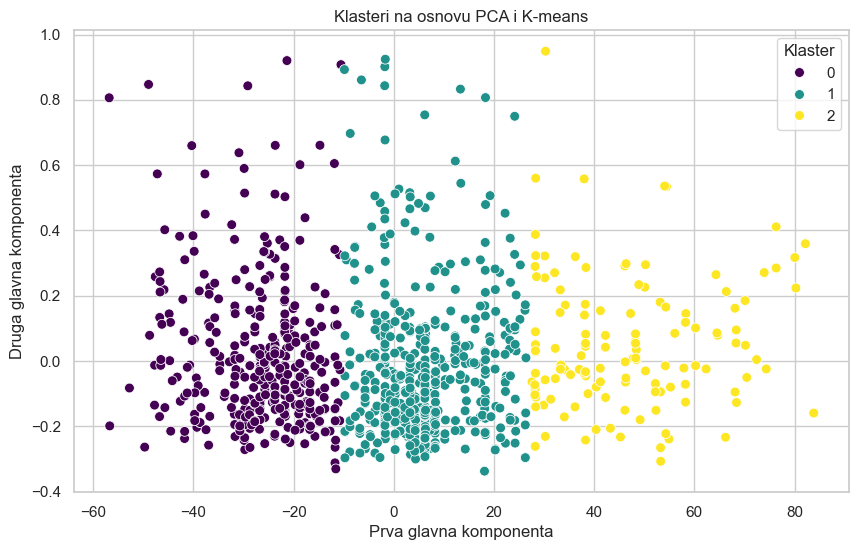

In [251]:
#KLASTERI 2010-2019

pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_scaled_2010_2019)
kmeans = KMeans(n_clusters=3, random_state=1)
clusters = kmeans.fit_predict(X_pca)
data_2010_2019['Cluster2'] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data_2010_2019['Cluster2'], palette='viridis', s=50)
plt.title('Klasteri na osnovu PCA i K-means')
plt.xlabel('Prva glavna komponenta')
plt.ylabel('Druga glavna komponenta')
plt.legend(title='Klaster')
plt.show()


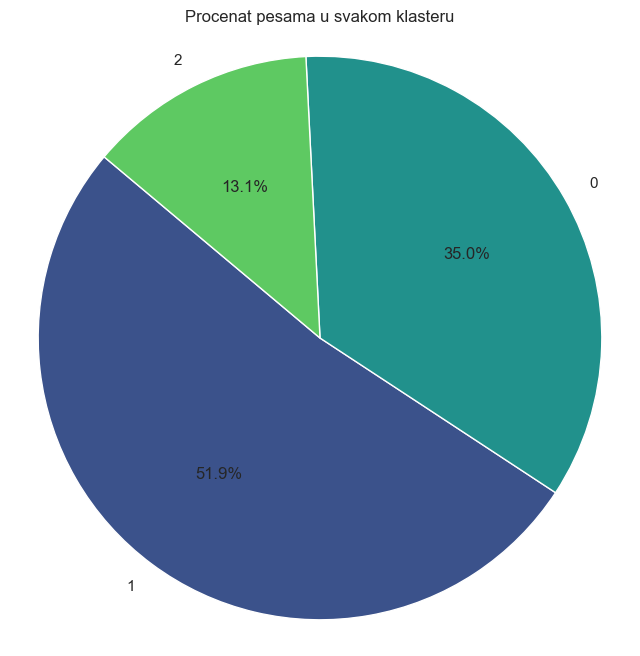

In [252]:
cluster_counts = data_2010_2019['Cluster2'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(cluster_counts)))
plt.title('Procenat pesama u svakom klasteru')
plt.axis('equal')
plt.show()

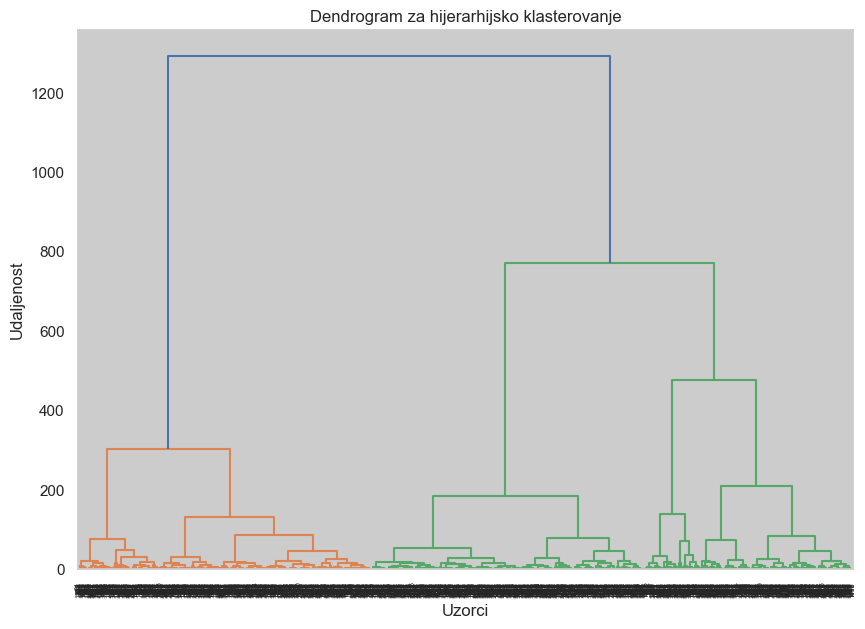

In [253]:
#Hijerarhijsko klasterovanje

pca = PCA(n_components=2)
pca_result = pca.fit_transform(data[features])

data['PCA1_1'] = pca_result[:, 0]
data['PCA2_1'] = pca_result[:, 1]

Z = linkage(data[['PCA1_1', 'PCA2_1']], method='ward')


plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram za hijerarhijsko klasterovanje')
plt.xlabel('Uzorci')
plt.ylabel('Udaljenost')
plt.show()

max_d = 3 
clusters = fcluster(Z, max_d, criterion='maxclust')

data['Hierarchical_Cluster'] = clusters


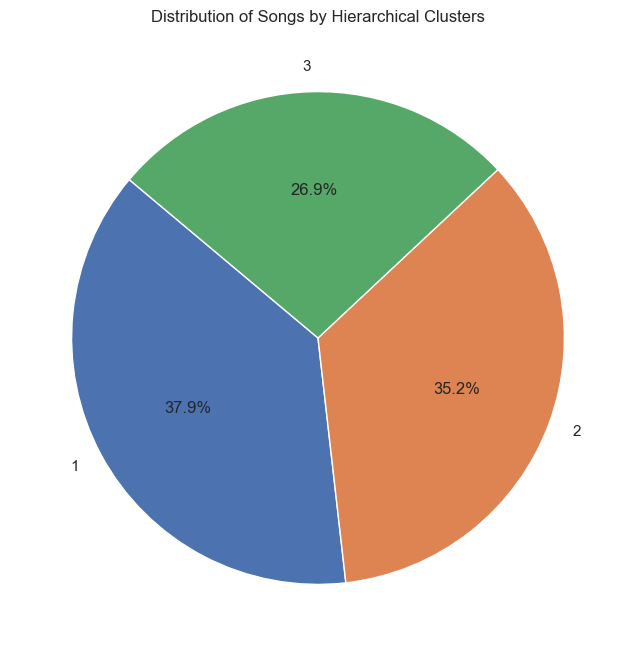

In [254]:

cluster_counts = data['Hierarchical_Cluster'].value_counts()

# Kreiranje pie charta
plt.figure(figsize=(8, 8))
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Songs by Hierarchical Clusters')
plt.show()

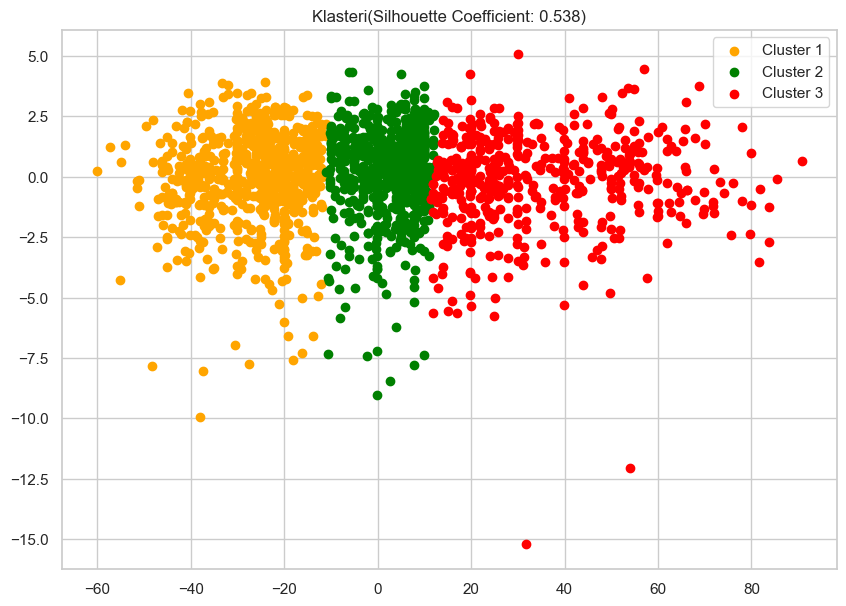

In [255]:
colors = ['orange', 'green', 'red', 'blue', 'purple', 'brown']

plt.figure(figsize=(10, 7))

for i in range(1, max(clusters) + 1):
    cluster = data[data['Hierarchical_Cluster'] == i]
    plt.scatter(cluster['PCA1_1'], cluster['PCA2_1'], color=colors[i - 1], label='Cluster %d' % i)

silhouette_avg = silhouette_score(data[['PCA1_1', 'PCA2_1']], clusters)
plt.title('Klasteri(Silhouette Coefficient: %0.3f)' % silhouette_avg)
plt.legend()
plt.show()

In [256]:
cluster_means = data.groupby('Hierarchical_Cluster')[features].mean()
cluster_means

,Danceability,Energy,Loudness,Speechiness,Acousticness,Instrumentalness,Tempo
Hierarchical_Cluster,,,,,,,
1,0.676407,0.687117,-5.690567,0.115719,0.148519,0.008027,93.262346
2,0.697013,0.753094,-5.311915,0.078890,0.113321,0.023343,122.607022
3,0.616879,0.727740,-5.490511,0.121847,0.117243,0.015871,154.694348


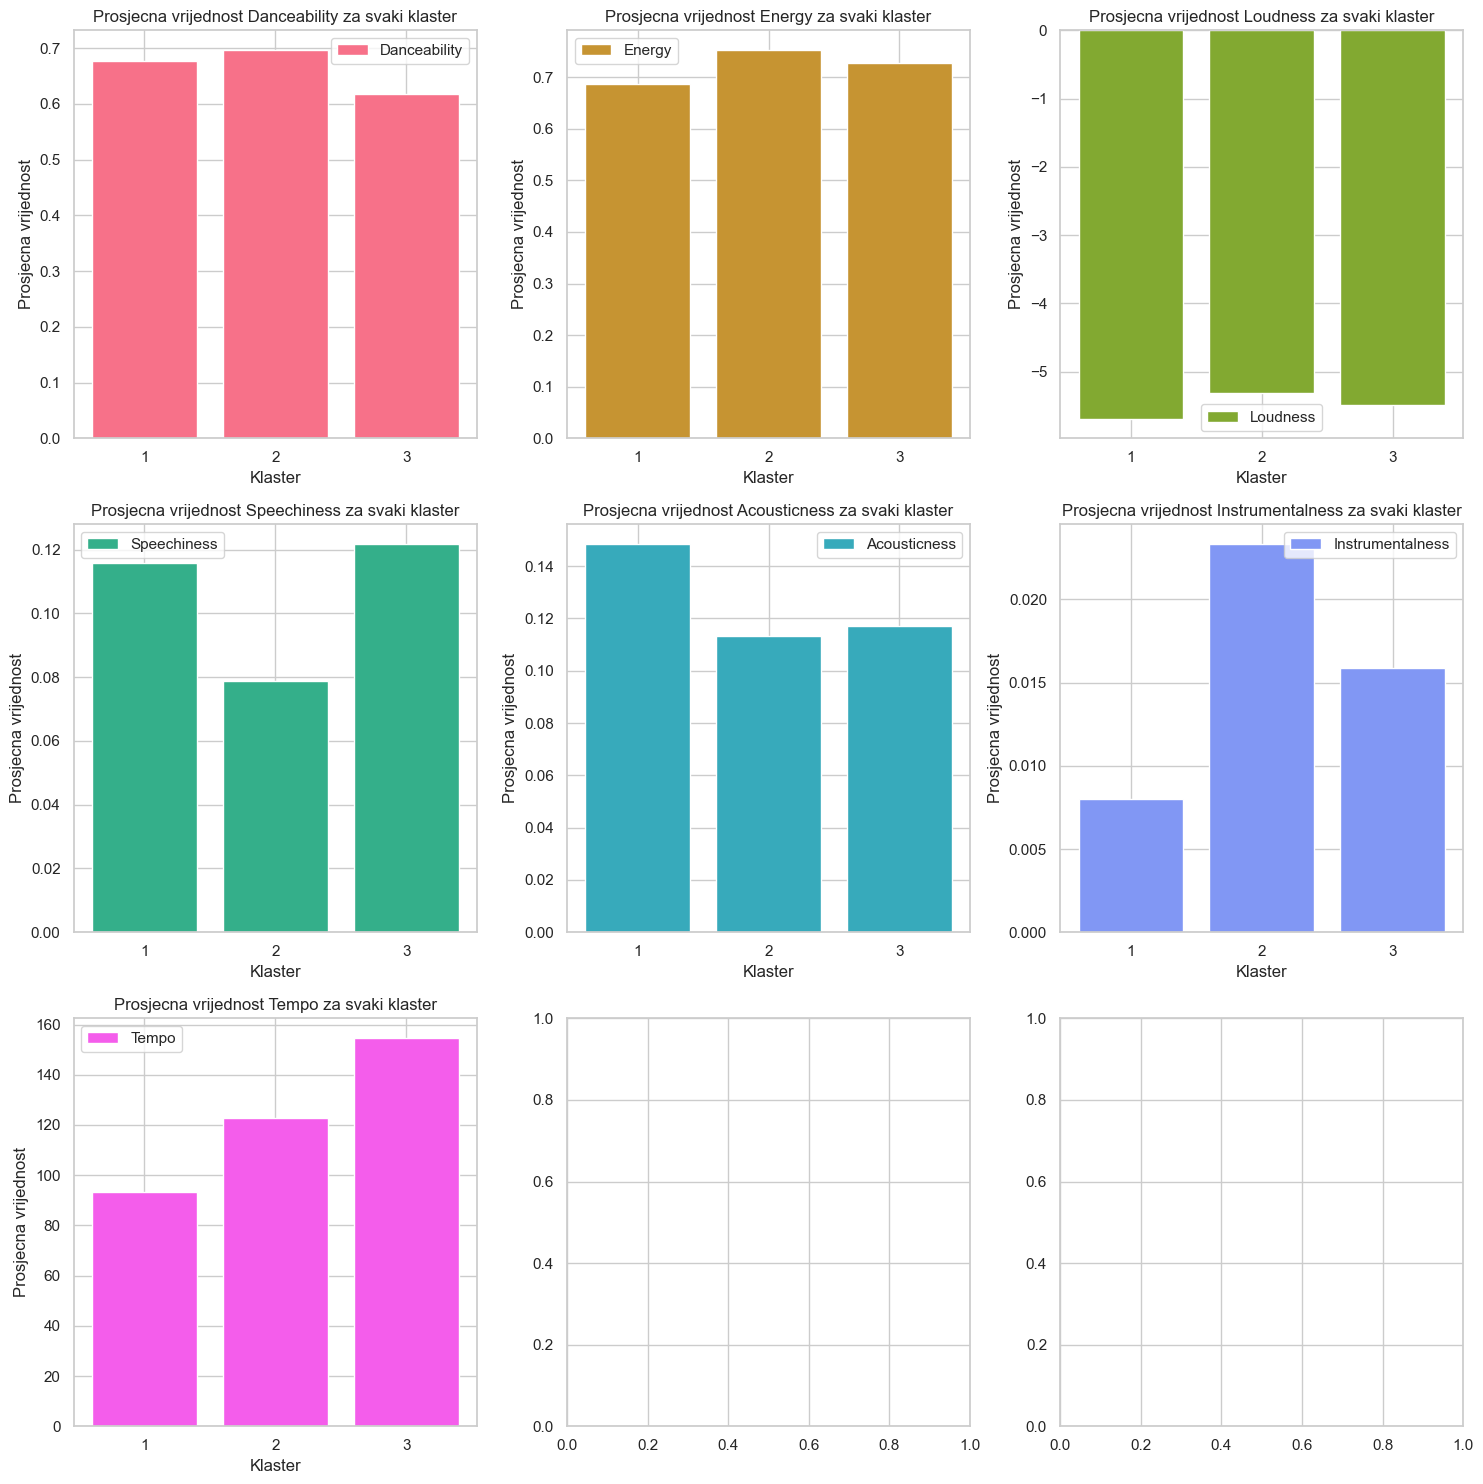

In [257]:
#Raspodjela karakteristika po klasterima

sns.set(style="whitegrid")
colors = sns.color_palette("husl", len(features))

num_cols = min(len(features), 3)
num_rows = (len(features) + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows*5))

for i, feature in enumerate(features):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col] if num_rows > 1 else axes[col]
    
    ax.bar(cluster_means.index, cluster_means[feature], color=colors[i], label=feature)
    ax.set_xlabel('Klaster')
    ax.set_ylabel('Prosjecna vrijednost')
    ax.set_title(f'Prosjecna vrijednost {feature} za svaki klaster')
    ax.set_xticks(cluster_means.index) 
    ax.set_xticklabels(cluster_means.index)
    ax.legend()


plt.tight_layout()
plt.show()

In [258]:
# Pronalaženje pjesama koje se ne nalaze u istim klasterima
different_clusters = data[(data['Cluster'] ==2 ) & (data['Hierarchical_Cluster']==1)][['Song', 'Cluster', 'Hierarchical_Cluster']]

# Ispisivanje rezultata
print("Pjesme koje nisu u istim klasterima u klasterima i hijerarhijskim klasterima:")
print(different_clusters)


Pjesme koje nisu u istim klasterima u klasterima i hijerarhijskim klasterima:
                                        Song  Cluster  Hierarchical_Cluster
0                     Oops!...I Did It Again        2                     1
6                        The Real Slim Shady        2                     1
7                                    Rock DJ        2                     1
15                                 Try Again        2                     1
20                                In the End        2                     1
...                                      ...      ...                   ...
1987                               gone girl        2                     1
1988                              High Hopes        2                     1
1989                         One Thing Right        2                     1
1997                              The Git Up        2                     1
1998  Dancing With A Stranger (with Normani)        2                     1

[720 rows

Silhouette Coefficient: -0.23445238846001282


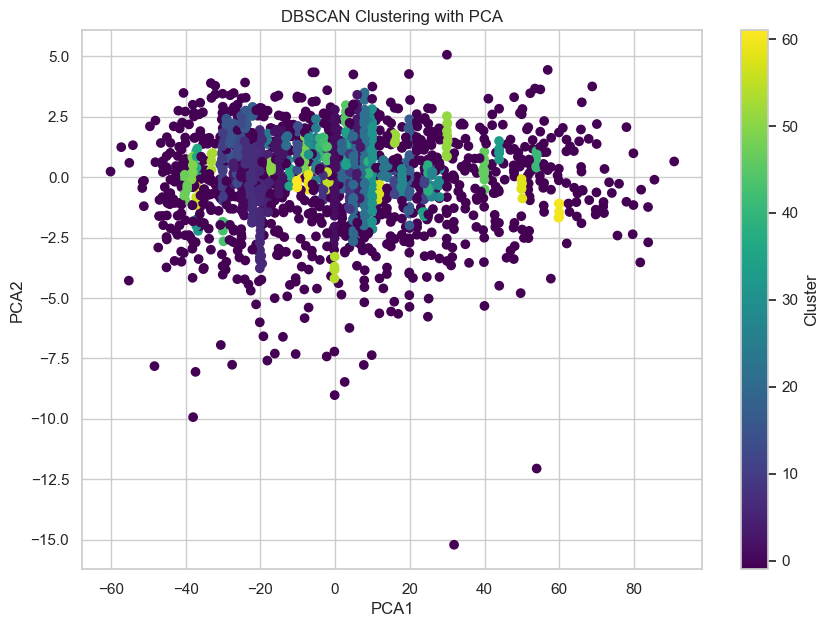

In [259]:

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score



# Primjena PCA na podatke
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data[features])

# Dodavanje rezultata PCA analize u DataFrame
data['PCA1'] = pca_result[:, 0]
data['PCA2'] = pca_result[:, 1]

# Izračunavanje DBSCAN klasterovanja na PCA rezultatima
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(data[['PCA1', 'PCA2']])

# Dodavanje klastera u originalni DataFrame
data['DBSCAN_Cluster'] = clusters

# Izračunavanje silhouette koeficijenta
silhouette_avg = silhouette_score(data[['PCA1', 'PCA2']], clusters)
print("Silhouette Coefficient:", silhouette_avg)

# Vizualizacija DBSCAN klasterovanja
plt.figure(figsize=(10, 7))
plt.scatter(data['PCA1'], data['PCA2'], c=clusters, cmap='viridis')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('DBSCAN Clustering with PCA')
plt.colorbar(label='Cluster')
plt.show()

